# Paper replication

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch

from collections import Counter
from copy import deepcopy
from IPython.display import clear_output
from scipy.stats import entropy
from tqdm import tqdm

from ca_funcs import get_network_entropies, make_table_walk, make_ca, make_glider
from train_ca import initialize_model
from utils import all_combinations

from nni.compression.torch import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
M = 2
D = (3, 3)
ALL_INPUTS = all_combinations(M, D)
RANDOM_INPUTS = np.random.choice([0, 1], (500, 10, 10))

## Define CAs and training data

In [195]:
def sample_CAs(rng=None):   
    rng = rng or np.random.default_rng(0)
    inputs = ALL_INPUTS
    outputs = make_table_walk(len(ALL_INPUTS), rng=rng)
    for o in outputs:
        yield make_ca(inputs, o)

def generate_CA_train_data(ca, height=10, width=10, n_samples=500, rng=None, noise=0.0):
    rng = rng or np.random.default_rng(0)
    X_train = torch.from_numpy(rng.choice([0, 1], (n_samples, height, width), p=[.5, .5])).float()
    Y_train = ca(X_train).float()
    foo = Y_train.detach().clone()
    flat_Y_train = Y_train.view(-1)
    flat_Y_indices = rng.choice(range(Y_train.numel()), size=int(Y_train.numel() * noise), replace=False)
    flat_Y_train[flat_Y_indices] = 1 - flat_Y_train[flat_Y_indices]
    return X_train, Y_train

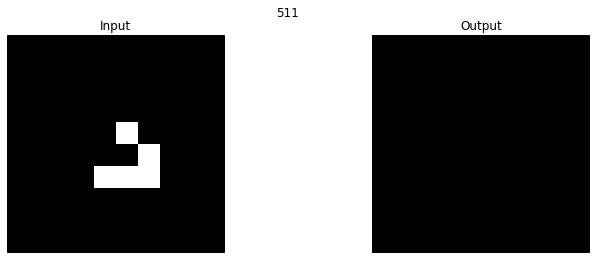

In [4]:
np.random.seed(0)

for i, ca in enumerate(sample_CAs()):
    X_test = torch.from_numpy(make_glider(10).reshape(1, 10, 10)).float()
    Y_test = ca(X_test).float()

    plt.figure(figsize=(12,4))
    plt.suptitle(i)

    plt.subplot(1,2,1)
    plt.imshow(X_test[0])
    plt.axis('off')
    plt.title("Input")

    plt.subplot(1,2,2)
    plt.imshow(Y_test[0])
    plt.axis('off')
    plt.title("Output")

    plt.show()
    plt.close()
    clear_output(wait=True)

## Find entropy of the training CA

In [5]:
def ca_entropy(ca):        
    inputs = torch.from_numpy(ALL_INPUTS)
    outputs = ca(inputs)
    output_counts = np.array(list(Counter(tuple(torch.reshape(o, [-1]).numpy()) for o in outputs).values()))
    output_ps = output_counts / len(inputs)
    return entropy(output_ps, base=2)

512it [00:12, 40.31it/s]


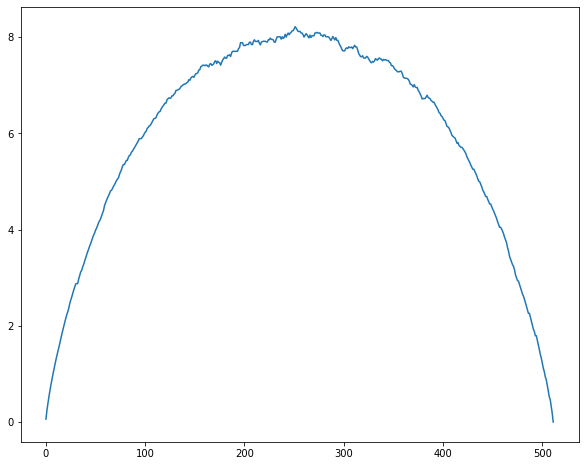

In [8]:
entropies = [ca_entropy(a) for a in tqdm(sample_CAs(rng=np.random.default_rng(0)))]
plt.plot(entropies)

## Define the model

In [235]:
seed = 0
print('seed =', seed)

np.random.seed(seed)
torch.random.manual_seed(seed)

num_classes = 2
samples = 500
input_dims = [10, 10]
layer_dims = [100] + [100] * 11  # neighborhood conv + mlpconv layers
batch_size = 10
num_batches = samples // batch_size
learning_rate = 1e-4
training_epochs = 100  # 1500
display_step = int(training_epochs / 10)
loss = torch.nn.MSELoss()

train_noise=0.2

model = initialize_model(input_dims, layer_dims)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

if torch.cuda.is_available():
    model.cuda()

seed = 0
Sequential(
  (Wraparound2D): Wraparound2D()
  (Conv2d_0): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1))
  (ReLU_0): ReLU()
  (Conv2d_1): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_1): ReLU()
  (Conv2d_2): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_2): ReLU()
  (Conv2d_3): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_3): ReLU()
  (Conv2d_4): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_4): ReLU()
  (Conv2d_5): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_5): ReLU()
  (Conv2d_6): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_6): ReLU()
  (Conv2d_7): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_7): ReLU()
  (Conv2d_8): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_8): ReLU()
  (Conv2d_9): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_9): ReLU()
  (Conv2d_10): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_10): ReLU()
  (Conv2d_1

## Define the learning loop

In [236]:
losses = []

def learn_CA(ca, model, optimizer, training_epochs, rng=None, train_noise=0.0):
    rng = rng or np.random.default_rng(0)
    losses = []
    X_train, Y_train = generate_CA_train_data(ca, *input_dims, n_samples=samples, rng=rng, noise=train_noise)
    if torch.cuda.is_available():
        X_train = X_train.cuda()
        Y_train = Y_train.cuda()

    for _ in tqdm(range(training_epochs)):
        batch_losses = []
        for i in range(num_batches):
            X_batch = X_train[i * batch_size : (i + 1) * batch_size]
            Y_batch = Y_train[i * batch_size : (i + 1) * batch_size]

            optimizer.zero_grad()
            Y_pred = model(X_batch)
            l = loss(Y_batch, Y_pred)
            l.backward()
            optimizer.step()
            batch_losses.append(l.item())
        losses.append(np.mean(batch_losses))
    return losses

## Train the model

In [ ]:
ca = list(sample_CAs(rng=np.random.default_rng(0)))[24]
losses = learn_CA(ca, model, optimizer, training_epochs, rng=np.random.default_rng(0), train_noise=train_noise)

 60%|██████    | 60/100 [01:42<01:09,  1.73s/it]

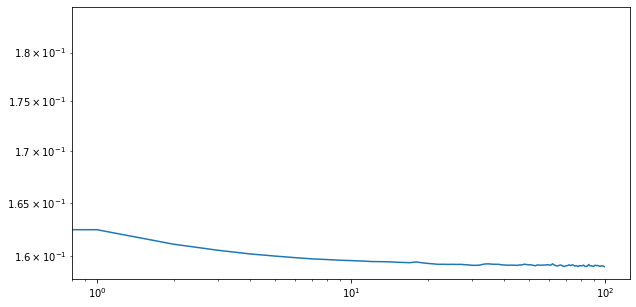

In [215]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.loglog();

max loss: 0.097876616


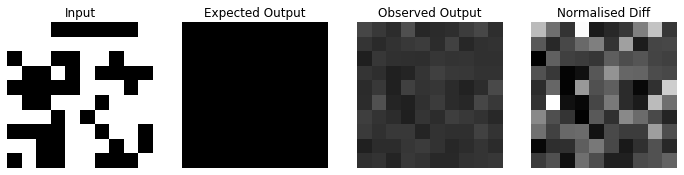

In [219]:
x = np.random.default_rng(0).choice([0, 1], size=100)
# x = make_glider(10)
X_test = torch.from_numpy(x.reshape(1, 10, 10)).float()
Y_test = ca(X_test).float()

if torch.cuda.is_available():
    X_test = X_test.cuda()
Y_pred = model(X_test)


if torch.cuda.is_available():
    X_test = X_test.cpu()
    Y_pred = Y_pred.cpu()

X_test = X_test.detach().numpy()
Y_test = Y_test.detach().numpy()
Y_pred = Y_pred.detach().numpy()

plt.figure(figsize=(12, 4))

plt.subplot(141)
plt.imshow(X_test[0])
plt.axis('off')
plt.title("Input")

plt.subplot(142)
plt.imshow(Y_test[0])
plt.axis('off')
plt.title("Expected Output")

plt.subplot(143)
plt.imshow(Y_pred[0], vmin=0, vmax=1)
plt.axis('off')
plt.title("Observed Output")

plt.subplot(144)
plt.imshow((Y_pred[0] - Y_test[0]) ** 2)
plt.axis('off')
plt.title("Normalised Diff")

print('max loss:', ((Y_pred[0] - Y_test[0]) ** 2).max())

## Find model entropies

In [220]:
def calculate_entropies(model):
    def get_activations(x_input):
        activations = []
        for m in model.children():
            x_input = m(x_input)
            activations.append(x_input)
        return activations[1:-3:2]

    X_test = np.pad(all_combinations(2, (3, 3)), [(0, 0), (3, 4), (3, 4)], 'wrap')
    X_test = torch.from_numpy(X_test).float()
        
    if torch.cuda.is_available():
        X_test = X_test.cuda()

    res = [activation.cpu().detach().numpy() for activation in get_activations(X_test)]
    layer_activations = np.array(res)
    # Layer activations are floats, but to calculate entropy,
    # we want to map activations to binary values,
    # 1 if a given activation is >0, and 0 otherwise.
    binary_activations = np.digitize(layer_activations, [0], right=True)
    binary_activations = binary_activations.transpose(0, 1, -2, -1, 2) \
        .reshape(len(layer_dims), np.product(X_test.shape), layer_dims[0])
    return get_network_entropies(binary_activations)

In [221]:
ca_entropy(ca)

0.06116285224115448

In [222]:
calculate_entropies(model)

(8.79856952502345,
 [8.79856952502345,
  8.79856952502345,
  8.79856952502345,
  8.79856952502345,
  8.79856952502345,
  8.79606952502345,
  8.795125915645746,
  8.79856952502345,
  8.791682306268042,
  8.79856952502345,
  8.755446596892805,
  8.738228550004283],
 [array([0.66055628, 0.93573145, 0.85115776, 0.90025676, 0.98451557,
         0.97203684, 0.98606803, 0.61295961, 0.79711281, 0.8341981 ,
         0.50927053, 0.86628685, 0.68821229, 0.38882599, 0.98958752,
         1.        , 0.69753259, 0.956707  , 0.57266539, 0.7354668 ,
         0.99398529, 0.34698129, 0.69621226, 1.        , 0.62526241,
         0.52394711, 0.86217453, 0.98958752, 0.92361752, 0.26476503,
         0.32992096, 0.99729213, 0.93350864, 0.93350864, 0.70796314,
         0.76919283, 0.16866093, 0.93791473, 0.29692332, 0.81813898,
         0.27297086, 0.22186012, 0.25922919, 0.26476503, 0.98936893,
         0.96560148, 0.71053443, 0.84146464, 0.79917303, 0.48464774,
         0.94111578, 0.52394711, 0.29692332, 0

## Compression

In [223]:
def prune_model_and_test(model, Pruner, config):
    model_copy = deepcopy(model)
    pruner = Pruner(model_copy, config, optimizer=optimizer)
    pruner.compress()
    return model_copy

def display_test(model):
    x = make_glider(10)
    X_test = torch.from_numpy(x.reshape(1, 10, 10)).float()
    Y_test = ca(X_test).float()

    if torch.cuda.is_available():
        X_test = X_test.cuda()
    Y_pred = model(X_test)

    if torch.cuda.is_available():
        X_test = X_test.cpu()
        Y_pred = Y_pred.cpu()

    X_test = X_test.detach().numpy()
    Y_test = Y_test.detach().numpy()
    Y_pred = Y_pred.detach().numpy()

    plt.figure(figsize=(12, 4))

    plt.subplot(141)
    plt.imshow(X_test[0])
    plt.axis('off')
    plt.title("Input")

    plt.subplot(142)
    plt.imshow(Y_test[0])
    plt.axis('off')
    plt.title("Expected Output")

    plt.subplot(143)
    plt.imshow(Y_pred[0])
    plt.axis('off')
    plt.title("Observed Output")

    plt.subplot(144)
    plt.imshow((Y_pred[0] - Y_test[0]) ** 2)
    plt.axis('off')
    plt.title("Normalised Diff")

    print('max loss:', ((Y_pred[0] - Y_test[0]) ** 2).max())

### Level Pruner

max loss: 0.05466455


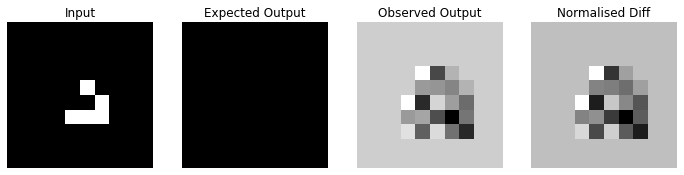

In [224]:
config_list = [{ 'sparsity': 0.1, 'op_types': ['default'] }]
m = prune_model_and_test(model, LevelPruner, config_list)
display_test(m)

### FPGM Pruner

max loss: 0.26723096


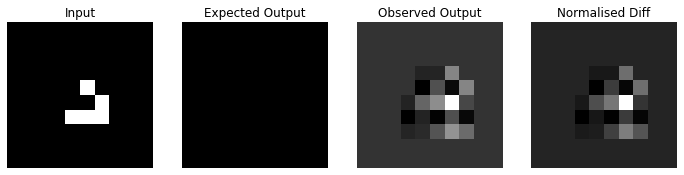

In [225]:
config_list = [{ 'sparsity': 0.1, 'op_types': ['Conv2d'] }]
m = prune_model_and_test(model, FPGMPruner, config_list)
display_test(m)

### L1 Pruner

max loss: 0.03633286


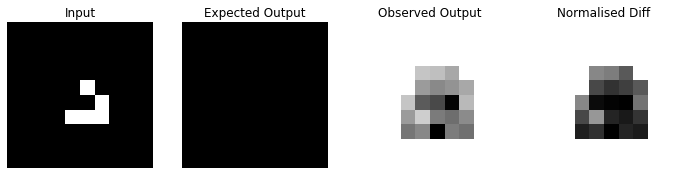

In [226]:
config_list = [{ 'sparsity': 0.1, 'op_types': ['Conv2d'] }]
m = prune_model_and_test(model, L1FilterPruner, config_list)
display_test(m)

### L2 Pruner

max loss: 0.14555667


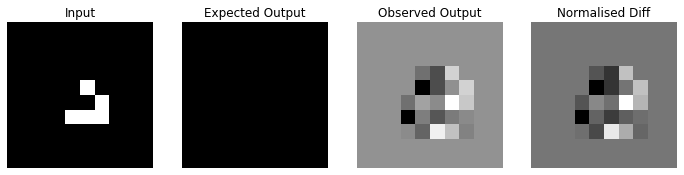

In [227]:
config_list = [{ 'sparsity': 0.1, 'op_types': ['Conv2d'] }]
m = prune_model_and_test(model, L2FilterPruner, config_list)
display_test(m)

### LotteryTicket Pruner

max loss: 0.05946715


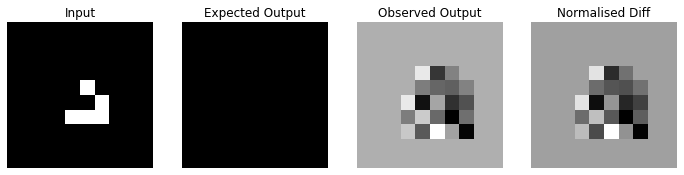

In [228]:
config_list = [{
    'prune_iterations': 50,
    'sparsity': 0.1,
    'op_types': ['default']
}]
m = prune_model_and_test(model, LotteryTicketPruner, config_list)
display_test(m)

## LMC Complexity

In [229]:
def lmc_complexity(P, N):
    P = np.array(P)
    P = P / P.sum()
    H = entropy(P, base=2)
    
    if N <= np.finfo(P.dtype).max:
        uniform_ps = np.full(len(P), 1.0 / N)
        D = np.sum((P - uniform_ps) ** 2) + (N - len(P)) * (1.0 / N)**2
    else:
        # assuming N >> len(P) >= 1 >= P, so that len(P)/N, 1/N and P/N are negligible
        D = np.sum(P ** 2)
        
    return H * D

def ca_lmc(ca, m=M, d=D):  
    inputs = torch.from_numpy(ALL_INPUTS)
    outputs = ca(inputs)
    output_counts = np.array(list(Counter(tuple(torch.reshape(o, [-1]).numpy()) for o in outputs).values()))
    output_ps = output_counts / len(inputs)
    return lmc_complexity(output_ps, m ** np.product(d))

512it [00:11, 42.70it/s]


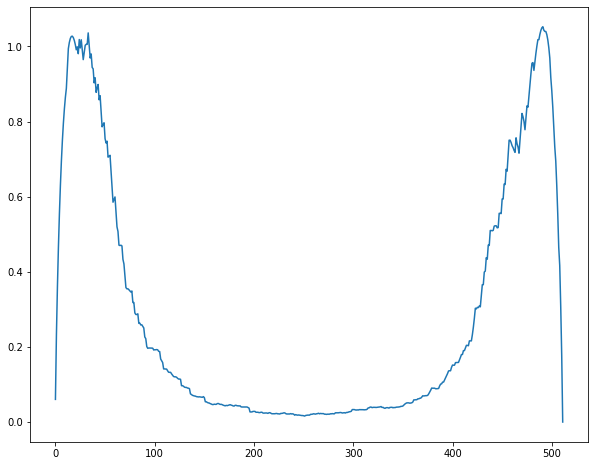

In [26]:
lmcs = [ca_lmc(a) for a in tqdm(sample_CAs(np.random.default_rng(0)))]
plt.plot(lmcs)

In [27]:
def get_network_lmcs(layers_samples_neurons):
    neuron_lmcs_by_layer = []
    layer_lmcs = []
    
    layer_count = layers_samples_neurons.shape[0]
    neuron_count = layers_samples_neurons.shape[2]
    
    for l in layers_samples_neurons:
        neuron_ps = l.mean(axis=0)
        neuron_lmcs_by_layer.append(np.array([lmc_complexity([p, 1-p], 2) for p in neuron_ps]))
        
        layer_patterns = (tuple(sample) for sample in l)
        layer_pattern_counts = list(Counter(layer_patterns).values())
        layer_lmcs.append(lmc_complexity(layer_pattern_counts, 2 ** neuron_count))
        
    network_patterns = (tuple(sample.ravel()) for sample in layers_samples_neurons.swapaxes(0, 1))
    network_pattern_counts = list(Counter(network_patterns).values())
    network_lmc = lmc_complexity(network_pattern_counts, 2 ** (layer_count * neuron_count))
    
    return network_lmc, layer_lmcs, neuron_lmcs_by_layer

def model_lmc(model):
    def get_activations(x_input):
        activations = []
        for m in model.children():
            x_input = m(x_input)
            activations.append(x_input)
        return activations[1:-3:2]

    X_test = np.pad(all_combinations(2, (3, 3)), [(0, 0), (3, 4), (3, 4)], 'wrap')
    X_test = torch.from_numpy(X_test).float()
        
    if torch.cuda.is_available():
        X_test = X_test.cuda()

    res = [activation.cpu().detach().numpy() for activation in get_activations(X_test)]
    layer_activations = np.array(res)
    # Layer activations are floats, but to calculate lmc complexity,
    # we want to map activations to binary values,
    # 1 if a given activation is >0, and 0 otherwise.
    binary_activations = np.digitize(layer_activations, [0], right=True)
    binary_activations = binary_activations.transpose(0, 1, -2, -1, 2) \
        .reshape(len(layer_dims), np.product(X_test.shape), layer_dims[0])
    return get_network_lmcs(binary_activations)

In [230]:
ca_lmc(ca)

0.060329441183852375

In [231]:
model_lmc(model)

(0.023233722652015048,
 [0.023233722652015048,
  0.023233722652015048,
  0.023233722652015048,
  0.023233722652015048,
  0.023233722652015048,
  0.023254608806780742,
  0.02327959890797483,
  0.023233722652015048,
  0.0233254321188174,
  0.023233722652015048,
  0.024036436985532282,
  0.024917604849621584],
 [array([0.1427813 , 0.0410618 , 0.08474938, 0.06079265, 0.01052893,
         0.01871854, 0.00949168, 0.14910434, 0.1067359 , 0.09213718,
         0.15244735, 0.07777699, 0.13766181, 0.13963835, 0.00712503,
         0.        , 0.13569243, 0.02842092, 0.15206458, 0.12638595,
         0.00413824, 0.13131507, 0.13597896, 0.        , 0.14776709,
         0.15281286, 0.07970804, 0.00712503, 0.048031  , 0.10962596,
         0.12738274, 0.0018707 , 0.04235868, 0.04235868, 0.13334098,
         0.11634042, 0.07610825, 0.03978004, 0.1189215 , 0.09871933,
         0.11209399, 0.09568567, 0.1079244 , 0.10962596, 0.00727263,
         0.02283949, 0.13273727, 0.08902696, 0.10598033, 0.15123433,
 

In [232]:
cas = np.array([ca for ca in sample_CAs(rng=np.random.default_rng(0))])
ca_entropies = np.array([ca_entropy(ca) for ca in cas])
ca_lmcs = np.array([ca_lmc(ca) for ca in cas])

In [233]:
i_test = np.r_[0:8:2, 8:128:16, 128:256:32]
i_test = np.sort(np.r_[i_test, 511 - i_test, 255])

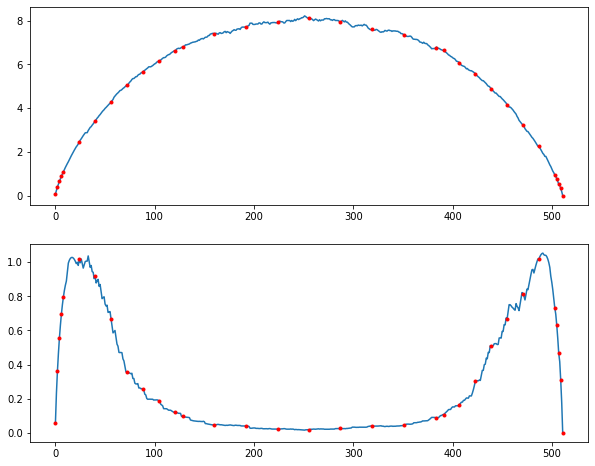

In [33]:
plt.subplot(211)
plt.plot(ca_entropies)
plt.plot(i_test, ca_entropies[i_test], 'r.')
plt.subplot(212)
plt.plot(ca_lmcs)
plt.plot(i_test, ca_lmcs[i_test], 'r.')
plt.show()